# Answers: Lab Week 5

## EOSC 211

### Learning Objectives:

1. Apply our skills with conditional statements `if elif else` to an earth sciences problem

2. Make code robust against the range of possible user-supplied inputs

3. Generate plots with annotations
___

## Part 1: The `plt.annotate()` Function and Formatted Text (Tutorial)

This lab will focus on applying some of the new concepts we have learned to work with data very similar to what we have seen before. This week's dataset is a *digital elevation model* (DEM) and your challenge is to write a program for the analysis of topographic slopes. Usually datasets are not provided with slopes, instead elevation data are stored in a Digital Elevation Model (DEM), which is basically a large array containing elevation above some datum (usually sea level) over a grid of points. You already saw a DEM in the lab for Week 3, though we didn’t call it by that name. The program you write let a "user" pick a point on a plot of the DEM, then calculate the slope at that point, and use formatted text to tell you whether that point is east-facing, west-facing, or relatively flat. Your code will have to take into account that the world is round if you select a point on the edge of the DEM. A useful way of writing this kind of program is to proceed in a few steps:

* Break up the problem into parts.   One technique useful for programs handling a lot of ‘special cases’ is to make it work for only one of the cases as a starting point.

* In this case we won’t make you start from scratch - instead you will work through code we have given you to get you started making sure you understand what each line does, Then you have to add a piece of code that does the right thing if the input data is ‘good’.

* Then, think about ways in which the input data can be ‘bad’.  Add code to test for these conditions and to handle them in a useful way. This code will often get squeezed into the middle of the existing code.

___
Start by importing our required packages as usual, and importing our dataset:

In [1]:
from e211_lib import e211 
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# get the data and query the size of the array
topo = e211.load_topo("lab5_topo.mat")
print(f'Data has shape {topo.shape}') # rows, columns

Data has shape (180, 360)


- Note that the shape of the data is (180, 360) which means that each row in the array corresponds to one degree _latitude_, and each column corresponds to one degree in _longitude_. This means that the _resolution_ of this dataset is one degree in lat/lon.

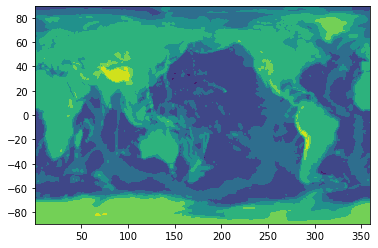

In [3]:
# create lat and lon arrays just like week 3 lab
lats = np.linspace(-89.5, 89.5, topo.shape[0])
lons = np.linspace(0.5, 359.5, topo.shape[1])

# see if our labels correctly match the plot
plt.contourf(lons, lats, topo);

Does everything look alright with our preliminary data visualization? Note that the scaling of the axes is a little bit off: if the units in the x and y direction are equal (both are in degrees), then we should expect that the length of the x-axis should be twice the length of the y-axis. However the 360 degrees of longitude are not represented as twice the length of the 180 degrees of latitude. While not strictly necessary, we can fix this visualization next time we plot with ```plt.axis('equal')```. Also note that without a colorbar, we don't actually know what each colour on this contour plot represents, nor can we visualize what units of elevation are being used here!

___


Let's continue on to the **data processing** phase:

We would like to our program to reference points on our map by their latitude/longitude coordinates, and be able to take in any arbitrary pair of coordinates and process the closest available point on the map. We could use python's built in [input()](https://www.w3schools.com/python/ref_func_input.asp) function to assign coordinate variables based on user input.  Testing code with an `input()` function call is difficult however.  Ideally, you want
to be able to reproduce your tests to check how future changes to your code change your results.  Another
issue is automation -- how do you
automatically test code in dozens of notebooks when each requires a user to enter a choice?   
For this lab, we'll 
use the the variables `usrlat` and `usrlon` to set choices a user could make about latitude/longitude coordinates.
Once you've set those `usrlat/usrlon`, you can use the [argmin()](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) method of numpy arrays
to find the closest point on the map to the user specified lat/lon.  

Make sure you understand what the code is doing in the following cell by working through it line-by-line.  We need to make sure to properly differentiate between the *lat/lon coordinates* of a location (which a user will specify), the *array value* (i.e height above sea level stored in the array `topo`), and the *array index* that references that point in the array.

In [4]:
#
# Change usrlat and usrlon to your own selection
#
usrlat = 50 # (deg N) 
usrlon = 50 # (deg E)

# assign new variables for the closest indexes to user specified lat & lon
ilat = np.abs(lats-usrlat).argmin()   # this can also be written ilat=np.argmin(np.abs(lats-usrlat))
ilon = np.abs(lons-usrlon).argmin()

# print out a message using f strings
print(f"User specified variables: lat: {usrlat}, lon: {usrlon}")
print(f"Closest values in array: lat: {lats[ilat]}, lon: {lons[ilon]} at indices [{ilat}, {ilon}]")
print(f"Value of topo array at that point: {topo[ilat, ilon]} m")

User specified variables: lat: 50, lon: 50
Closest values in array: lat: 49.5, lon: 49.5 at indices [139, 49]
Value of topo array at that point: 0 m


___
For the *output* of this program, we'll use the `plt.annotate()` function to label our user-selected point on the map, as well as display the elevation at that point. Later, you will build on this cell to add more information and present it as a polished scientific figure. This cell uses the function twice, once to draw a red X and once to label the point with some information. Check out the [docs for plt.annotate()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html) for more info on how to implement the function.

Again work through the code below, line by line to make sure you understand exactly what the syntax is doing.  e.g. what does `\n` do?  what does the `f` mean? Why do we use `usrlon+10` in the second call of `plt.annotate()`? What is contained in the variable `the_label`?

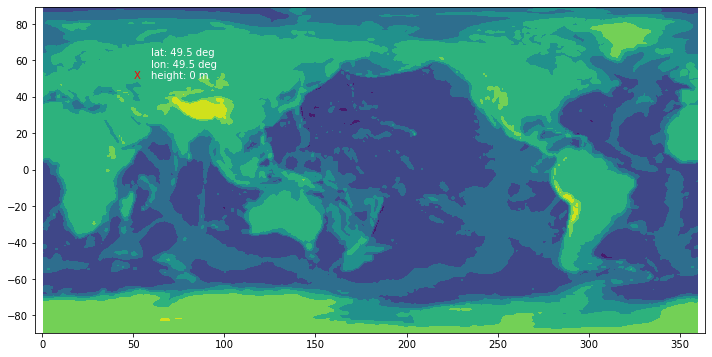

In [5]:
# output
fig = plt.figure(figsize=(12,6))  # make the figure a bit bigger
img = plt.contourf(lons, lats, topo)
plt.axis('equal')  # set axis scaling to equal

plt.annotate("X", (usrlon, usrlat), color="red")
the_label = f"lat: {lats[ilat]} deg\nlon: {lons[ilon]} deg\nheight: {topo[ilat, ilon]} m"
plt.annotate(the_label, (usrlon + 10, usrlat), color='white');

___
## Part 2:  Calculate the topographic slope:

Your task is to solve the following problem: What is the east/west slope (in degrees) at the `usrlat,usrlon` point you specify in the cell above? The east/west slope is a height difference between the point immediately to the RIGHT (or EAST) of the one you picked and the one immediately to the LEFT (or WEST) of it,  divided by the horizontal distance of these two points (think $slope = \frac{rise}{run}$). Then take the arc-tangent to get the result in degrees:

$$
slope \approx tan^{-1}\left(\frac{topo(i, j+1) - topo(i, j-1)}{\Delta lon \cdot 111e3 \cdot cos(lat)}\right)
$$

Make sure that you understand why the denominator in the equation above gives the horizontal distance of two points at the same latitude.  This is a key thing to know in earth / planetary science!  A picture might help -- think back to arc lengths on a circle.


### Table 1: 
<a name="table-1-constants"></a>

| Symbol  | Units      | Description    |
| :----------- | :-----------: |  :--------------------------------|
| $topo$|  height [m]| topography array |
| $i,j$ | [-] | lat, lon indices |
|$\Delta lon $|degrees | change in longitude between two points  | 
|$111e3$| metres/degree | at the equator, 1 degree=111000m   | 
|$lat$ | degrees| latitude of the point selected   |
|$\cos{lat}$|  [-]| correction factor for longitude convergence at the poles   |



___
### 2a

In the cell below, write code to make this work for points well within the array (i.e. away from the edges of the map). Make sure the trigonometric functions you use are for degrees and not radians. You may find the functions `np.deg2rad()` and `np.rad2deg()` helpful.  Print the value of your slope as the last line of your cell.

In [6]:
### BEGIN SOLUTION
# andrew's soln
slope = np.rad2deg(np.arctan((topo[ilat, ilon + 1] 
                              - topo[ilat, ilon - 1]) 
                              / (2 * 111e3 
                              * np.cos(np.deg2rad(usrlat)))))
slope
### END SOLUTION

-0.009636368489360649

___
### 2b

Use `if` `elif` `else` blocks to print the following message to the screen:

(i)  The latitude and longitude of the selected point (note - latitudes can be N or S, longitudes can always be E)

(ii)  The elevation AND the slope at that point (in degrees)

(iii)  A  message  saying  “Flat”  if  the  slope  angle  is  between  -0.1  and  +0.1  degrees,  “East-facing,” or “West-facing” if the slope is larger and either east or west facing, respectively. An “east-facing” slope tilts DOWN towards the east. Use *f string literals* to compose the message in a nicely formatted way, something like:

       At 30.5 N, 100.5 E, the height is 4014 m and the slope is -0.188 degrees. This is east-facing.
       
In part 3, you will create a scientific figure with the slope and aspect annotated on the plot. For now, print the message as the last line in the cell.

In [7]:
### BEGIN SOLUTION
# andrew's soln

# formatting for latitude
if int(usrlat) < 0:
    latdir = "S"
else:
    latdir = "N"

# formatting for slope direction
if slope > 0.1:
    aspect = "west-facing"
elif slope < -0.1:
    aspect = "east-facing"
else:
    aspect = "flat"

# make a formatted string
out_msg = f"At {lats[ilat]} {latdir}, {lons[ilon]} E, the height is \
{topo[ilat, ilon]} m and the slope is {np.round(slope,3)} degrees. This is {aspect}."

print(out_msg)
### END SOLUTION

At 49.5 N, 49.5 E, the height is 0 m and the slope is -0.01 degrees. This is flat.


___
##  Part 3: Selections - Check Arguments


Often with user input, your program has to first check their validity to make sure they don’t crash the program or get an unwanted (incorrect) result. We already implemented code to make sure to reference the *closest available point to the input*, rather than trusting that input will precisely match the values in the arrays `lats` and `lons`. 

In general, it is a good strategy to write code to handle the majority of possible cases, running it, then modifying  to account for "edge cases" as needed.

What other "bad" inputs can we anticipate that would result in buggy output? What if the user enters `usrlat,usrlon` values at the edge of the map (ie `usrlon = 355.5`), such that there is no $j+1$ element of the array? What about `usrlon = 0`? Modify your code from part **2a** as necessary to handle these possibilities. (**hint:** Do you encounter the same problem on both the left and right edges of the map? Why/why not?) 

___
## To Hand In:

In the cell(s) below, write a self contained program (you can recycle code from earlier parts of the lab) that runs through the whole process of *import/input, data scrubbing, presentation.*

#### Import/Input
This part should be pretty trivial, just copy/paste the appropriate code from above.  As before, use the variables
`usrlat` and `usrlon` to hold your lat/lon coordinates.

#### Data Scrubbing
Use `if` `elif` `else` statements to handle the possible special cases for user input.  Assume that we
will run your code for arbitrary values of `usrlat` and `usrlon` and test a variety of possibilities yourself.

#### Output
Generate a scientific figure with the following:

* An X marking the selected location
* Text beside the X specifying the lat, lon, elevation, slope, and aspect (E or W facing) of the point
* All the regular fixings for a scientific figure:

<div class="alert alert-block alert-info">
<b>Scientific Figure Checklist:</b> 

- [ ] Title 
- [ ] Axes labels with units 
- [ ] Legend
- [ ] Does the figure *make sense* just by looking at it? The data should be clear without referencing anything outside the figure
- [ ] Does it *look good*? 
</div>

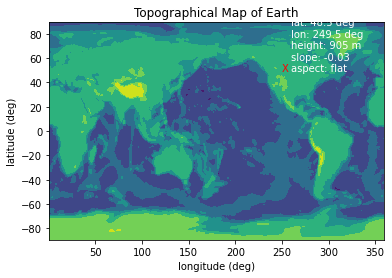

In [8]:
### BEGIN SOLUTION
# andrew's soln

### imports ###
from e211_lib import e211 
from matplotlib import pyplot as plt
import numpy as np

### inputs ###

# dataset
topo = e211.load_topo("lab5_topo.mat")
lats = np.linspace(-89.5, 89.5, topo.shape[0])
lons = np.linspace(0.5, 359.5, topo.shape[1])

# user inputs
usrlat =  49.
usrlon =  250.
ilat = np.abs(lats-usrlat).argmin()
ilon = np.abs(lons-usrlon).argmin()


### processing ###

# filter inputs
if ilon == len(lons)-1:
    ilon = 0
# (dont need to do anything for ilon = 0 case, indexing [-1] automatically solves it!)

# calculate slope    
slope = np.rad2deg(np.arctan((topo[ilat, ilon + 1] 
                              - topo[ilat, ilon - 1]) 
                              / (2 * 111e3 
                              * np.cos(np.deg2rad(usrlat)))))
 
# formatting for slope direction
if slope > 0.1:
    aspect = "west"
elif slope < -0.1:
    aspect = "east"
else:
    aspect = "flat"
    
# generate a variable to place the label correctly (bonus?)
if ilon < 250:
    offset = 10
else:
    offset = -70
    
### output ###

fig, ax = plt.subplots()
ax.contourf(lons, lats, topo)
ax.annotate("X", (usrlon, usrlat), color="red")
the_label = (
    f"lat: {lats[ilat]} deg\nlon: {lons[ilon]} deg\nheight: {topo[ilat, ilon]} m"
    + f"\nslope: {round(slope,3)}\naspect: {aspect}"
)
ax.annotate(the_label, (usrlon + offset, usrlat), color="white")
ax.set_xlabel("longitude (deg)")
ax.set_ylabel("latitude (deg)")
ax.set_title("Topographical Map of Earth");
### END SOLUTION